<a href="https://colab.research.google.com/github/BirgittPeeters/GenAI-SuperResolution/blob/main/2d_superres_square_img_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q "monai-weekly[tqdm]"
!python -c "import generative" || pip install -q monai-generative
!python -c "import lpips" || pip install -q lpips
!python -c "import pydicom" || pip install -q pydicom
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'generative'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'lpips'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pydicom'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.7 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import tempfile
import subprocess
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.7.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

checkpoint_dir = os.path.join(root_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

/tmp/tmpankbvecs


In [ ]:
!pip install --quiet idc-index
import pydicom
import subprocess
import random
from pydicom.pixel_data_handlers.util import apply_voi_lut
from idc_index import index

  Preparing metadata (setup.py) ... done


In [ ]:
# IDC data download script
collection_id = "cmb_lca"  # Replace with the actual collection ID
client = index.IDCClient()
query = f"""
SELECT
  series_aws_url
FROM
  index
WHERE
  Modality = 'MR'
  AND collection_id = '{collection_id}'
"""
result = client.sql_query(query)

In [ ]:
# Extract S3 URLs
s3_urls = result.series_aws_url.tolist()



In [ ]:
# Randomly select a subset for training and validation
random.seed(42)  # Set a seed for reproducibility
random.shuffle(s3_urls)

train_size = 40
validation_size = 30

In [ ]:
train_urls = s3_urls[:train_size]
validation_urls = s3_urls[train_size:train_size + validation_size]

In [ ]:
# Download DICOM files for training set
train_download_dir = os.path.join(root_dir, "MR_DICOM", "train")
os.makedirs(train_download_dir, exist_ok=True)

In [ ]:
for s3_url in tqdm(train_urls, desc="Downloading DICOM files for training set"):
    result = subprocess.run([client.s5cmdPath, '--no-sign-request', 'cp', s3_url, train_download_dir], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')

In [ ]:
# Download DICOM files for validation set
validation_download_dir = os.path.join(root_dir, "MR_DICOM", "validation")
os.makedirs(validation_download_dir, exist_ok=True)

In [ ]:
for s3_url in tqdm(validation_urls, desc="Downloading DICOM files for validation set"):
    result = subprocess.run([client.s5cmdPath, '--no-sign-request', 'cp', s3_url, validation_download_dir], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')

In [ ]:
# Custom DICOM Dataset class
class CustomDICOMDataset:
    def __init__(self, root_dir, spatial_size=(64, 64)):
        self.root_dir = root_dir
        self.class_names = self._find_classes()
        self.spatial_size = spatial_size
        self.data = self._load_dataset()
        self.max_image_size = self._find_max_image_size()

    def _find_classes(self):
        class_names = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
        return class_names

    def _load_dataset(self):
        data = []  # List to store file paths and class names
        for class_name in self.class_names:
            class_path = os.path.join(self.root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(".dcm"):
                    file_path = os.path.join(class_path, file)
                    data.append({"image": file_path, "class_name": class_name})
        return data

    def _find_max_image_size(self):
        max_size = [0, 0]
        for item in self.data:
            dcm = pydicom.dcmread(item['image'])
            max_size[0] = max(max_size[0], dcm.Rows)
            max_size[1] = max(max_size[1], dcm.Columns)
        return tuple(max_size)

    def __getitem__(self, index):
        item = self.data[index]
        class_name = item['class_name']
        return {'file_path': item['image'], 'class_name': class_name}

    def __len__(self):
        return len(self.data)

In [ ]:
# Create a custom dataset
train_data = CustomDICOMDataset(os.path.join(root_dir, "MR_DICOM"))
max_image_size = train_data.max_image_size
# max_res = max(max_image_size)
max_res = 256

In [ ]:
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "train"]

In [ ]:
train_transforms = transforms.Compose([
    transforms.LoadImageD(keys=["image"]),  # Use LoadImageD for DICOM files
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.Resized(keys=["image"],spatial_size=(max_res, max_res)),
    transforms.NormalizeIntensityd(keys=["image"]),
    transforms.RandAffined(
        keys=["image"],
        rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
        translate_range=[(-1, 1), (-1, 1)],
        scale_range=[(0.95, 1.05), (0.95, 1.05)],
        spatial_size=(max_res, max_res),  # Adjusted spatial_size for 2D
        padding_mode="border",
        prob=0.5,
    ),
    transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
    transforms.Resized(keys=["low_res_image"], spatial_size=(max_res/4, max_res/4)),
])

# Apply the transformation to the dataset without caching
train_ds = Dataset(data=train_datalist, transform=train_transforms)
sample = train_ds[0]

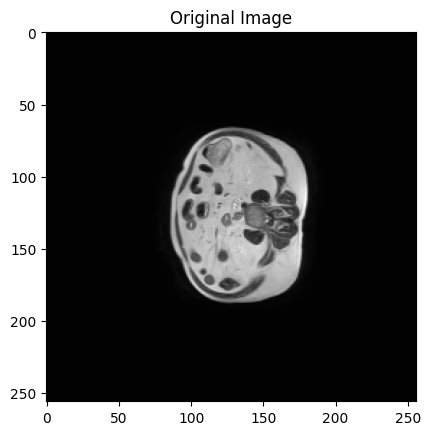

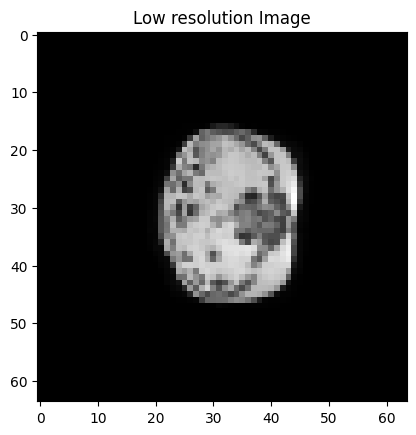

In [ ]:
#%% extra check for dataset
sample = train_ds[0]
original_image = sample["image"]
low_res_image = sample["low_res_image"]

plt.imshow(original_image[0, :, :], cmap="gray")
plt.title("Original Image")
plt.show()

plt.imshow(low_res_image[0,:,:], cmap="gray")
plt.title("Low resolution Image")
plt.show()

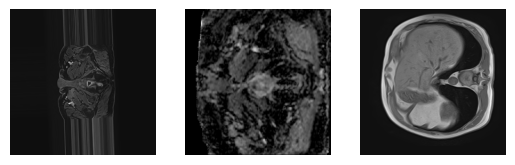

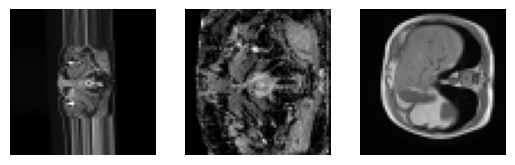

In [ ]:
train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=0)
# # Apply the transformation to the dataset
# train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=4, persistent_workers=True)
# %%
#Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

# %%
# Plot 3 examples from the training set in low resolution
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["low_res_image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

In [ ]:
# ## Create data loader for validation set
val_data = CustomDICOMDataset(os.path.join(root_dir, "MR_DICOM"))
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "validation"]

In [ ]:
val_transforms = transforms.Compose(
    [
        transforms.LoadImageD(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Resized(keys=["image"],spatial_size=(max_res, max_res)),
        transforms.NormalizeIntensityd(keys=["image"]),
        transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
        transforms.Resized(keys=["low_res_image"], spatial_size=(max_res/4,max_res/4)),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=5, shuffle=True, num_workers=0)

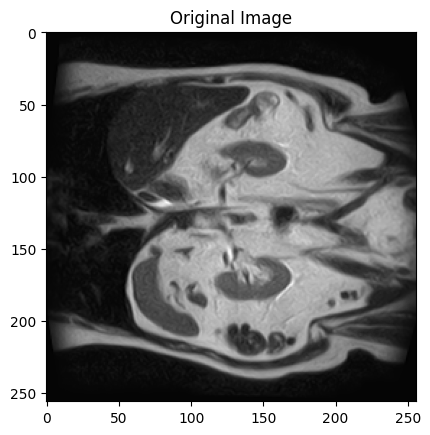

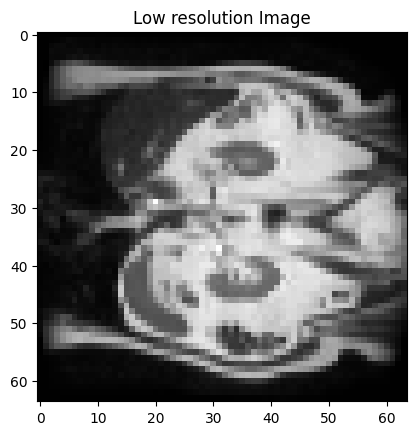

In [ ]:
sample = val_ds[15]
original_image = sample["image"]
low_res_image = sample["low_res_image"]

plt.imshow(original_image[0, :, :], cmap="gray")
plt.title("Original Image")
plt.show()

plt.imshow(low_res_image[0,:,:], cmap="gray")
plt.title("Low resolution Image")
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

In [ ]:
# Define autoencoder
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(256, 512, 512),
    latent_channels=3,
    num_res_blocks=2,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1, num_layers_d=3, num_channels=64)
discriminator = discriminator.to(device)

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.002

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.005

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=5e-5)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# %%
scaler_g = GradScaler()
scaler_d = GradScaler()
accumulation_steps = 4

In [ ]:
import gc

In [ ]:
 # ## Train Autoencoder

# %%
kl_weight = 1e-6
n_epochs = 75
val_interval = 10
autoencoder_warm_up_n_epochs = 10

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            optimizer_d.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                reconstruction, z_mu, z_sigma = autoencoderkl(images)
                recons_loss = F.l1_loss(images.float(), reconstruction.float())
                val_loss += recons_loss.item()

        val_loss /= val_step
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

        # ploting reconstruction
        plt.figure(figsize=(2, 2))
        plt.imshow(torch.cat([images[0, 0].cpu(), reconstruction[0, 0].cpu()], dim=1), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

In [ ]:
# ## Train Diffusion Model
#
# In order to train the diffusion model to perform super-resolution, we will need to concatenate the latent representation of the high-resolution with the low-resolution image. For this, we create a Diffusion model with `in_channels=4`. Since only the outputted latent representation is interesting, we set `out_channels=3`.

# %%
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(256, 256, 512, 1024),
    attention_levels=(False, False, True, True),
    num_head_channels=(0, 0, 64, 64),
)
unet = unet.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)


In [ ]:
# %%
low_res_scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

max_noise_level = 350

In [ ]:
# %%
optimizer = torch.optim.Adam(unet.parameters(), lr=5e-5)

scaler_diffusion = GradScaler()

n_epochs = 200
val_interval = 20
epoch_loss_list = []
val_epoch_loss_list = []

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        low_res_image = batch["low_res_image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            with torch.no_grad():
                latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor

            # Noise augmentation
            noise = torch.randn_like(latent).to(device)
            low_res_noise = torch.randn_like(low_res_image).to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device).long()
            low_res_timesteps = torch.randint(
                0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
            ).long()

            noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
            noisy_low_res_image = scheduler.add_noise(
                original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
            )

            latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)

            noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler_diffusion.scale(loss).backward()
        scaler_diffusion.step(optimizer)
        scaler_diffusion.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        for val_step, batch in enumerate(val_loader, start=1):
            images = batch["image"].to(device)
            low_res_image = batch["low_res_image"].to(device)

            with torch.no_grad():
                with autocast(enabled=True):
                    latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor
                    # Noise augmentation
                    noise = torch.randn_like(latent).to(device)
                    low_res_noise = torch.randn_like(low_res_image).to(device)
                    timesteps = torch.randint(
                        0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device
                    ).long()
                    low_res_timesteps = torch.randint(
                        0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
                    ).long()

                    noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
                    noisy_low_res_image = scheduler.add_noise(
                        original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
                    )

                    latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)
                    noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
                    loss = F.mse_loss(noise_pred.float(), noise.float())

            val_loss += loss.item()
        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        sampling_image = low_res_image[0].unsqueeze(0)
        latents = torch.randn((1, 3, max_res//4, max_res//4)).to(device)
        low_res_noise = torch.randn((1, 1, max_res//4, max_res//4)).to(device)
        noise_level = 20
        noise_level = torch.Tensor((noise_level,)).long().to(device)
        noisy_low_res_image = scheduler.add_noise(
            original_samples=sampling_image,
            noise=low_res_noise,
            timesteps=torch.Tensor((noise_level,)).long().to(device),
        )

        scheduler.set_timesteps(num_inference_steps=1000)
        for t in tqdm(scheduler.timesteps, ncols=110):
            with torch.no_grad():
                with autocast(enabled=True):
                    latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
                    noise_pred = unet(
                        x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level
                    )
                latents, _ = scheduler.step(noise_pred, t, latents)

        with torch.no_grad():
            decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

        low_res_bicubic = nn.functional.interpolate(sampling_image, (max_res, max_res), mode="bicubic")
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(
            torch.cat([images[0, 0].cpu(), low_res_bicubic[0, 0].cpu(), decoded[0, 0].cpu()], dim=1),
            vmin=0,
            vmax=1,
            cmap="gray",
        )
        plt.tight_layout()
        plt.axis("off")
        plt.show()

        # Save both autoencoder and U-Net diffusion model checkpoints
        checkpoint_filename = os.path.join(checkpoint_dir, f"combined_model_checkpoint_epoch_{epoch + 1}.pt")
        torch.save({
            'epoch': epoch,
            'autoencoderkl_state_dict': autoencoderkl.state_dict(),
            'unet_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_diffusion_state_dict': scaler_diffusion.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            # Add other necessary information
        }, checkpoint_filename)

In [ ]:
# ### Plotting sampling example

# %%
# Sampling image during training
unet.eval()
num_samples = 5
validation_batch = first(val_loader)

images = validation_batch["image"].to(device)
sampling_image = validation_batch["low_res_image"].to(device)[:num_samples]

# %%
latents = torch.randn((num_samples, 3, max_res//4, max_res//4)).to(device)
low_res_noise = torch.randn((num_samples, 1, max_res//4, max_res//4)).to(device)
noise_level = 10
noise_level = torch.Tensor((noise_level,)).long().to(device)
noisy_low_res_image = scheduler.add_noise(
    original_samples=sampling_image, noise=low_res_noise, timesteps=torch.Tensor((noise_level,)).long().to(device)
)
scheduler.set_timesteps(num_inference_steps=1000)
for t in tqdm(scheduler.timesteps, ncols=110):
    with torch.no_grad():
        with autocast(enabled=True):
            latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
            noise_pred = unet(x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level)

        # 2. compute previous image: x_t -> x_t-1
        latents, _ = scheduler.step(noise_pred, t, latents)

with torch.no_grad():
    decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

# %%
low_res_bicubic = nn.functional.interpolate(sampling_image, (max_res, max_res), mode="bicubic")
fig, axs = plt.subplots(num_samples, 3, figsize=(8, 8))
axs[0, 0].set_title("Original image")
axs[0, 1].set_title("Low-resolution Image")
axs[0, 2].set_title("Outputted image")
for i in range(0, num_samples):
    axs[i, 0].imshow(images[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(low_res_bicubic[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(decoded[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 2].axis("off")
plt.tight_layout()

In [ ]:
if directory is None:
  shutil.rmtree(root_dir)